# Question 2b5_2
Compare the test accuracies and the running times of the networks implemented in parts (1) – (4).

Experiment with adding dropout to the layers of networks in parts (1) – (4), and report the test accuracies. Compare and comment on the accuracies of the networks with/without dropout.

# Imports and Setup

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# chuanxin
%cd "../gdrive/My Drive/cz4042_assignment_2/2b" 

Mounted at /gdrive
/gdrive/My Drive/cz4042_assignment_2/2b


In [ ]:
import os
import time
import json
import csv
import re
import collections

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# Helper functions

### read_data_words()
Used to load in the data. Returns x_train, y_train, x_test, y_test

In [ ]:
def read_data_words():
    x_train, y_train, x_test, y_test = [], [], [], []
    cop = re.compile("[^a-z^A-Z^0-9^,^.^' ']")
    with open('./train_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_train.append(data)
            y_train.append(int(row[0]))

    with open('./test_medium.csv', encoding='utf-8') as filex:
        reader = csv.reader(filex)
        for row in reader:
            data = cop.sub("", row[1])
            x_test.append(data)
            y_test.append(int(row[0]))

    word_dict = build_word_dict(x_train+x_test)
    x_train = preprocess(x_train, word_dict, MAX_DOCUMENT_LENGTH)
    y_train = np.array(y_train)
    x_test = preprocess(x_test, word_dict, MAX_DOCUMENT_LENGTH)
    y_test = np.array(y_test)

    x_train = [x[:MAX_DOCUMENT_LENGTH] for x in x_train]
    x_test = [x[:MAX_DOCUMENT_LENGTH] for x in x_test]
    x_train = tf.constant(x_train, dtype=tf.int64)
    y_train = tf.constant(y_train, dtype=tf.int64)
    x_test = tf.constant(x_test, dtype=tf.int64)
    y_test = tf.constant(y_test, dtype=tf.int64)

    vocab_size = tf.get_static_value(tf.reduce_max(x_train))
    vocab_size = max(vocab_size, tf.get_static_value(tf.reduce_max(x_test))) + 1
    return x_train, y_train, x_test, y_test, vocab_size

### clean_str(text)
Cleans a text and gets right of unwanted characters

In [ ]:
def clean_str(text):
    text = re.sub(r"[^A-Za-z0-9(),!?\'\`\"]", " ", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = text.strip().lower()

    return text

### build_word_dict(contents)
Self-explanatory

In [ ]:
def build_word_dict(contents):
    words = list()
    for content in contents:
        for word in word_tokenize(clean_str(content)):
            words.append(word)

    word_counter = collections.Counter(words).most_common()
    word_dict = dict()
    word_dict["<pad>"] = 0
    word_dict["<unk>"] = 1
    word_dict["<eos>"] = 2
    for word, _ in word_counter:
        word_dict[word] = len(word_dict)
    return word_dict

### preprocess(contents, word_dict, document_max_len)
Clean up a string 

In [ ]:
def preprocess(contents, word_dict, document_max_len):
    x = list(map(lambda d: word_tokenize(clean_str(d)), contents))
    x = list(map(lambda d: list(map(lambda w: word_dict.get(w, word_dict["<unk>"]), d)), x))
    x = list(map(lambda d: d + [word_dict["<eos>"]], x))
    x = list(map(lambda d: d[:document_max_len], x))
    x = list(map(lambda d: d + (document_max_len - len(d)) * [word_dict["<pad>"]], x))
    return x

### make_directories()
Used to create directories that might not have been made

In [ ]:
# Create folder to store histories and figures
def make_directories():
  if not os.path.exists('./histories'):
    os.mkdir('./histories')
  if not os.path.exists('./figures'):
    os.mkdir('./figures')

### history_saver(history, filename, already_json=False)
Used to save a history object

In [ ]:
# filename like 'history/model_name.json'
def history_saver(history, model_name, already_json=False):
  history_json = {}

  if already_json:
    history_json = history
  else:
    history = history.history
    for key in history.keys():
      history_json[key] = history[key]

  with open('./histories/' + model_name, 'w') as file:
    json.dump(history_json, file)

  print("History saved")

### history_loader(filename)
Used to load in a json history object

In [ ]:
# filename like 'history/model_name.json'
def history_loader(model_name):
  with open('./histories/'+model_name) as json_file:
    history = json.load(json_file)
  print('History loaded')
  
  return history 

### plot_loss(history_json, model_name)
Plot out loss graph, and also save it

In [ ]:
def plot_loss(history_json, model_name):
  train_loss = history_json['loss']
  test_loss = history_json['test_loss']
  title = 'Model name: ' + model_name + '\nloss against epochs'

  plt.plot(train_loss, label='train')
  plt.plot(test_loss, label='test')
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig(f'./figures/{model_name}_loss.png')
  
  plt.show()

### plot_acc(history_json, model_name)
Plot out accuracy graph, and also save it

In [ ]:
def plot_acc(history_json, model_name):
  train_acc = history_json['accuracy']
  test_acc = history_json['test_accuracy']
  title = 'Model name: ' + model_name + '\naccuracy against epochs'

  plt.plot(train_acc, label='train')
  plt.plot(test_acc, label='test')
  plt.title(title)
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()
  plt.savefig(f'./figures/{model_name}_accuracy.png')
  
  plt.show()

# 2b5_2 - WordCNN (dropout)

In [ ]:
tf.keras.backend.set_floatx('float32')
class WordCNN(tf.keras.Model):
  def __init__(self, vocab_size, use_dropout):
    super(WordCNN, self).__init__()
    self.vocab_size = vocab_size
    self.use_dropout = use_dropout
    self.embedding = tf.keras.layers.Embedding(vocab_size, EMBEDDING_SIZE, input_length=MAX_DOCUMENT_LENGTH)
    
    # Weight variables and RNN cell
    self.conv1 = tf.keras.layers.Conv2D(N_FILTERS, FILTER_SHAPE1, padding='VALID', activation='relu', use_bias=True)
    self.pool1 = tf.keras.layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
    self.conv2 = tf.keras.layers.Conv2D(N_FILTERS, FILTER_SHAPE2, padding='VALID', activation='relu', use_bias=True)
    self.pool2 = tf.keras.layers.MaxPool2D(POOLING_WINDOW, POOLING_STRIDE, padding='SAME')
    self.flatten = tf.keras.layers.Flatten()
    self.dense = tf.keras.layers.Dense(MAX_LABEL, activation='softmax')

  def call(self, x, drop_rate):
    # forward
    x = self.embedding(x)
    x = x[..., tf.newaxis] 
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)    
    x = self.flatten(x)
    if self.use_dropout:
      x = tf.nn.dropout(x, drop_rate)
    logits = self.dense(x)
    return logits

In [ ]:
# Training function
def train_step(model, x, label, optimizer, drop_rate):
  with tf.GradientTape() as tape:
    out = model(x, drop_rate)
    loss = loss_object(label, out)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
      
  train_loss(loss)
  train_accuracy(label, out)

# Testing function
def test_step(model, x, label, drop_rate):
  out = model(x,drop_rate)
  t_loss = loss_object(label, out)
  test_loss(t_loss)
  test_accuracy(label, out)

In [ ]:
def fit(model):
  train_acc_list, train_loss_list, test_acc_list, test_loss_list = [], [], [], []
  time_start = time.perf_counter()

  for epoch in range(no_epochs):
    # Reset the metrics at the start of the next epoch
    train_accuracy.reset_states()
    train_loss.reset_states()
    test_accuracy.reset_states()
    test_loss.reset_states()

    for images, labels in train_ds:
      train_step(model, images, labels, optimizer, 0.5)

    for images, labels in test_ds:
      test_step(model, images, labels, 0)

    
    train_acc_list.append(train_accuracy.result())
    train_loss_list.append(train_loss.result())
    test_acc_list.append(test_accuracy.result())
    test_loss_list.append(test_loss.result())

    template = 'Epoch {}, train_accuracy: {}, train_loss: {}, test_accuracy: {}, test_loss: {}'
    print (template.format(epoch+1,
                          train_accuracy.result(),
                          train_loss.result(),
                          test_accuracy.result(),
                          test_loss.result()))

  time_stop = time.perf_counter()
  time_taken = time_stop-time_start

  return train_acc_list, train_loss_list, test_acc_list, test_loss_list, time_taken

### Parameters

In [ ]:
MAX_DOCUMENT_LENGTH = 100
N_FILTERS = 10
FILTER_SHAPE1 = [20, 20]
FILTER_SHAPE2 = [20, 1]
POOLING_WINDOW = 4
POOLING_STRIDE = 2
MAX_LABEL = 15
EMBEDDING_SIZE = 20

batch_size = 128
no_epochs = 400
lr = 0.01

In [ ]:
# Choose optimizer and loss function for training
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr)

# Select metrics to measure the loss and the accuracy of the model. 
# These metrics accumulate the values over epochs and then print the overall result.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [ ]:
# Training and test
make_directories()
x_train, y_train, x_test, y_test, vocab_size = read_data_words()

# Use `tf.data` to batch and shuffle the dataset:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

In [ ]:
model = WordCNN(vocab_size, True)
model_name = 'q5_2_word_cnn_dropout'
train_acc_list, train_loss_list, test_acc_list, test_loss_list, time_taken = fit(model)

Epoch 1, train_accuracy: 0.0682142823934555, train_loss: 2.705554723739624, test_accuracy: 0.06285714358091354, test_loss: 2.7025725841522217
Epoch 2, train_accuracy: 0.07678571343421936, train_loss: 2.700594186782837, test_accuracy: 0.0657142847776413, test_loss: 2.6985881328582764
Epoch 3, train_accuracy: 0.07160714268684387, train_loss: 2.698194980621338, test_accuracy: 0.06857142597436905, test_loss: 2.6952743530273438
Epoch 4, train_accuracy: 0.07678571343421936, train_loss: 2.694830894470215, test_accuracy: 0.06857142597436905, test_loss: 2.692026138305664
Epoch 5, train_accuracy: 0.07750000059604645, train_loss: 2.691070795059204, test_accuracy: 0.0714285746216774, test_loss: 2.6886370182037354
Epoch 6, train_accuracy: 0.07428571581840515, train_loss: 2.688706874847412, test_accuracy: 0.07571428269147873, test_loss: 2.685471534729004
Epoch 7, train_accuracy: 0.06589286029338837, train_loss: 2.687298059463501, test_accuracy: 0.07999999821186066, test_loss: 2.6823203563690186
Epoc

In [ ]:
for metric_list in [train_acc_list, train_loss_list, test_acc_list, test_loss_list]:
  metric_list[:] = [x.numpy() for x in metric_list]
  metric_list[:] = [x.astype(float) for x in metric_list]

In [ ]:
history_json = {model_name: {
    'accuracy': train_acc_list,
    'test_accuracy': test_acc_list,
    'loss': train_loss_list,
    'test_loss': test_loss_list,
    'time_taken': time_taken
}}

history_saver(history_json, model_name, already_json=True)
histories_json = history_loader(model_name)

History saved
History loaded


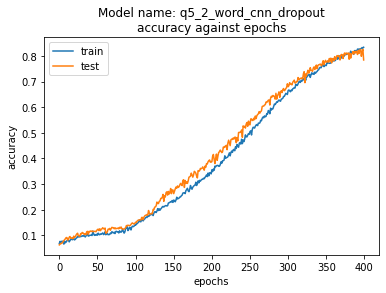

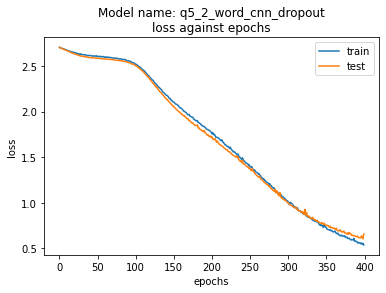

In [ ]:
plot_acc(histories_json[model_name], model_name)
plot_loss(histories_json[model_name], model_name)

In [ ]:
histories_json[model_name]['time_taken']

347.04594265400004